#Particle Swarm for Our Project

In [ ]:
#!pip install pyswarm
#!pip install git+https://github.com/pulse2percept/pulse2percept

## Defining Implants and What Not

In [ ]:
import numpy as np
import pulse2percept as p2p
from matplotlib import pyplot as plt
from pulse2percept.implants import DiskElectrode, ElectrodeGrid, ProsthesisSystem, AlphaAMS, ElectrodeArray
from pyswarm import pso

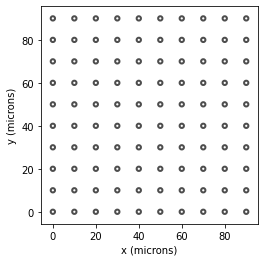

In [ ]:
# Define an electrode array
earray = ElectrodeArray({})
for x in range(0, 100, 10):
  for y in range(0, 100, 10):
    earray.add_electrode(f'{x}{y}', DiskElectrode(x, y, 0, 1))

implant = ProsthesisSystem(earray)
implant.plot()

In [ ]:
# Takes an array of tuples giving the electrode position

def buildElectrodeArray (electrodePositions, radius):
  earray = ElectrodeArray({})
  for position in electrodePositions:
    x = position[0]
    y = position[1]
    # print(x,y)
    earray.add_electrode(f'{x}{y}', DiskElectrode(x, y, 0, r=radius))

  implant = ProsthesisSystem(earray)

  return implant

def standardizeData (implant, model):
  percepts = []
  for name in implant.electrode_names:
    implant.stim = {name : 1}
    percept = model.predict_percept(implant)
    percepts.append(percept)

  allPixelData = []

  for percept in percepts:
    data = percept.data
    xy = percept.data
    F = xy.reshape(xy.shape[0], xy.shape[1])
    allPixelData.append(F)

  allPixelData = np.array(allPixelData)
  shape = allPixelData.shape
  allPixelData = allPixelData.reshape((shape[0], shape[1] * shape[2]))

  # Standardize:
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  scaler.fit(allPixelData)
  scaledData = scaler.transform(allPixelData)


  # 2. Apply PCA
  from sklearn.decomposition import PCA
  pca = PCA(n_components = 0.95)
  pca.fit(scaledData)
  
  # For some reason this returns Nan
  print("Num Effective Electrodes", len(pca.explained_variance_ratio_))
  #print(" variance ratio", pca.explained_variance_ratio_)
  return len(pca.explained_variance_ratio_)
 


In [ ]:
# The error function must accept a tuple of parameter values `params` first, but
# can have other input variables like `features` and `targets`

# targets is number of actual electrodes
# features is number of effective electrodes

def err_func(features, targets):
    return (targets - features)
    



## Making Our Own PySwarm Optimization Loop

In [ ]:
#!pip install pyswarms

### Install Relevant Packages

In [ ]:
import pyswarms as ps
import pyswarms.backend as P
from pyswarms.backend.swarms import Swarm
import pyswarms.backend as P
from pyswarms.backend.topology import Ring

### Build a new Model and Implants

In [ ]:
model = p2p.models.AxonMapModel(xrange= (-2.5, 2), yrange= (-2,2), xystep= 0.02, rho=75) 
model.build()

implant = p2p.implants.ArgusII()
init_positions = []
radius = 0
for name, electrode in implant.electrodes.items():
  radius = electrode.r
  init_positions.append((electrode.x, electrode.y))

init_positions = np.array(init_positions)
init_velocities = P.generate_velocity(n_particles=implant.n_electrodes, dimensions=2)

# modify these to change parameters of how particles move
my_options = {'c1': 2.3, 'c2': 1.9, 'w': 1.6}
# Initialize the swarm
my_swarm = Swarm(position=init_positions, velocity=init_velocities, options=my_options)

### Initial Implant 

Num Effective Electrodes 10
60 10


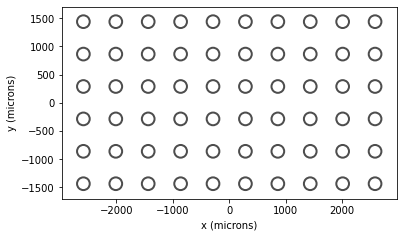

In [ ]:
implant = buildElectrodeArray(my_swarm.position, radius)
implant.plot()
effective = standardizeData (implant, model)
print(implant.n_electrodes, effective)

### Particle Swarm Part

In [ ]:
# bounds
search_params = {
    'a': (-2500, 2000),
    'b': (-2000, 2000)
}
lb = [v[0] for v in search_params.values()]
ub = [v[1] for v in search_params.values()]

bounds = (lb, ub)

In [ ]:
# The reason it's dropping now is because the search space isn't bounded 

# Supress/hide the warning
np.seterr(invalid='ignore')
my_topology = Ring() # The Topology Class

iterations = 100 # Set 100 iterations

for i in range(iterations):
    # Part 1: Update personal best
    implant = buildElectrodeArray(my_swarm.position, radius)
        #model = p2p.models.AxonMapModel(xrange= (-2.5, 2), yrange= (-2,2), xystep= 0.02, rho=75) 
        #model.build()
    effective = standardizeData (implant, model)
   
    # Computes current cost of electrodes
    my_swarm.current_cost = err_func(effective, implant.n_electrodes)

    if my_swarm.current_cost < my_swarm.best_cost:
      my_swarm.best_cost = my_swarm.current_cost
      my_swarm.best_pos = my_swarm.position


    # Part 3: Update position and velocity matrices
    # Note that position and velocity updates are dependent on your topology
    # Takes in the bounds 
    my_swarm.velocity = my_topology.compute_velocity(my_swarm)
    my_swarm.position = my_topology.compute_position(my_swarm, bounds)

print('The best cost found by our swarm is: {:.4f}'.format(my_swarm.best_cost))
print('The best position found by our swarm is: {}'.format(my_swarm.best_pos))

Num Effective Electrodes 10
Num Effective Electrodes 10
Num Effective Electrodes 11
Num Effective Electrodes 13
Num Effective Electrodes 12
Num Effective Electrodes 13
Num Effective Electrodes 12
Num Effective Electrodes 12
Num Effective Electrodes 13
Num Effective Electrodes 12
Num Effective Electrodes 14
Num Effective Electrodes 12
Num Effective Electrodes 13
Num Effective Electrodes 13
Num Effective Electrodes 13
Num Effective Electrodes 10
Num Effective Electrodes 13
Num Effective Electrodes 11
Num Effective Electrodes 12
Num Effective Electrodes 13
Num Effective Electrodes 10
Num Effective Electrodes 11
Num Effective Electrodes 15
Num Effective Electrodes 13
Num Effective Electrodes 13
Num Effective Electrodes 10
Num Effective Electrodes 12
Num Effective Electrodes 8
Num Effective Electrodes 11
Num Effective Electrodes 9
Num Effective Electrodes 10
Num Effective Electrodes 13
Num Effective Electrodes 9
Num Effective Electrodes 10
Num Effective Electrodes 9
Num Effective Electrodes

In [ ]:
# ## Probably going to 1 in the later iterations because it's optimizing the sphere
# Yeah it was. I fixed it above


# my_topology = Ring() # The Topology Class

# iterations = 100 # Set 100 iterations
# for i in range(iterations):
#     # Part 1: Update personal best
#     implant = buildElectrodeArray(my_swarm.position, radius)
#     effective = standardizeData (implant, model)
   
#     my_swarm.current_cost = err_func(effective, implant.n_electrodes) #f(my_swarm.position) # Compute current cost
#     my_swarm.pbest_cost = f(my_swarm.pbest_pos)  # Compute personal best pos
#     my_swarm.pbest_pos, my_swarm.pbest_cost = P.compute_pbest(my_swarm) # Update and store




#     # Part 2: Update global best
#     # Note that gbest computation is dependent on your topology
#     if np.min(my_swarm.pbest_cost) < my_swarm.best_cost:
#         my_swarm.best_pos, my_swarm.best_cost = my_topology.compute_gbest(my_swarm, 3, 4)

#     # Let's print our output
#     if i%10==0:
#         print('Iteration: {} | my_swarm.best_cost: {:.4f}'.format(i+1, my_swarm.best_cost))

#     # Part 3: Update position and velocity matrices
#     # Note that position and velocity updates are dependent on your topology
#     my_swarm.velocity = my_topology.compute_velocity(my_swarm)
#     my_swarm.position = my_topology.compute_position(my_swarm)

# print('The best cost found by our swarm is: {:.4f}'.format(my_swarm.best_cost))
# print('The best position found by our swarm is: {}'.format(my_swarm.best_pos))

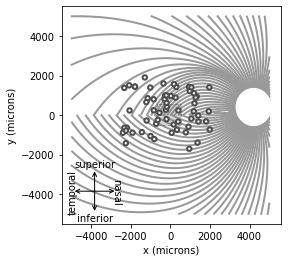

In [ ]:
implant = buildElectrodeArray(my_swarm.best_pos, radius)
model.plot()
implant.plot()

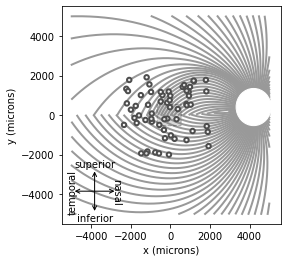

In [ ]:
implant = buildElectrodeArray(my_swarm.position, radius)
model.plot()
implant.plot()

In [ ]:
print(my_swarm.position)
print(my_swarm.best_pos)

[[ -940.  -336.]
 [-1204.  1910.]
 ...
 [-1480. -1936.]
 [  208. -1200.]]
[[ 1414.5   -328.  ]
 [-2258.19 -1422.69]
 ...
 [ 1966.12  1405.29]
 [  177.11  1568.63]]
